# Classifying VS from ALeRCE ZTF explorer

In [1]:
import matplotlib.pyplot as plt
from alerce.core import Alerce
import numpy as np
import pandas as pd
alerce = Alerce()

### Getting light curves from the ALeRCE client

In [2]:
%%time
classifiers = alerce.query_classifiers()
for clasifier in classifiers:
    print(clasifier['classifier_name'])
    print(clasifier['classes'])

lc_classifier
['SNIa', 'SNIbc', 'SNII', 'SLSN', 'QSO', 'AGN', 'Blazar', 'CV/Nova', 'YSO', 'LPV', 'E', 'DSCT', 'RRL', 'CEP', 'Periodic-Other']
lc_classifier_top
['Transient', 'Stochastic', 'Periodic']
lc_classifier_transient
['SNIa', 'SNIbc', 'SNII', 'SLSN']
lc_classifier_stochastic
['QSO', 'AGN', 'Blazar', 'CV/Nova', 'YSO']
lc_classifier_periodic
['LPV', 'E', 'DSCT', 'RRL', 'CEP', 'Periodic-Other']
stamp_classifier
['SN', 'AGN', 'VS', 'asteroid', 'bogus']
stamp_classifier
['SN', 'AGN', 'VS', 'asteroid', 'bogus']
CPU times: user 13.2 ms, sys: 973 µs, total: 14.2 ms
Wall time: 1.41 s


In [3]:
%%time
classes = ['LPV', 'E', 'DSCT', 'RRL', 'CEP', 'Periodic-Other']
objects_df = []
for cls in classes:
    params = {
       "classifier": "lc_classifier_periodic",
       "class_name": cls,
       "probability": 0.6,
       "page_size":20,
       "ndet":[300,]
    }
    objects = alerce.query_objects(**params)
    objects_df.append(objects)
objects_df = pd.concat(objects_df)

CPU times: user 17.5 ms, sys: 2.13 ms, total: 19.7 ms
Wall time: 1.92 s


In [4]:
objects_df_2 = objects_df.copy()
objects_df_2['class'] = objects_df['class'].replace({'SNIa':'SNI', 'SNIbc':'SNI'})

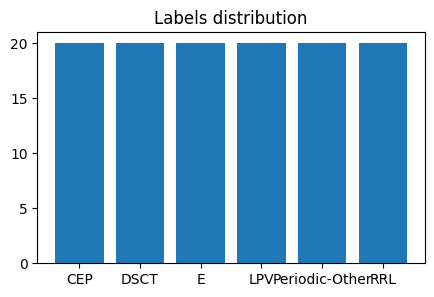

In [5]:
uniques, counts = np.unique(objects_df_2['class'], return_counts=True)

plt.figure(figsize=(5,3), dpi=100)
x_range = range(len(uniques))
plt.bar(x_range, counts)
plt.xticks(x_range, uniques)
plt.title('Labels distribution')
plt.show()

In [6]:
%%time
X, y = [], []
for index, row in objects_df_2.iterrows():
    det = alerce.query_detections(row['oid'],
                                  format="pandas",
                                  sort="mjd")
    lc = det[(det.fid == 1)][['mjd', 'magpsf', 'sigmapsf']]
    lc.dropna(inplace=True)
    lc.sort_values('mjd', inplace=True)
    X.append(lc.values)
    y.append(list(uniques).index(row['class']))

CPU times: user 1.2 s, sys: 170 ms, total: 1.37 s
Wall time: 1min 40s


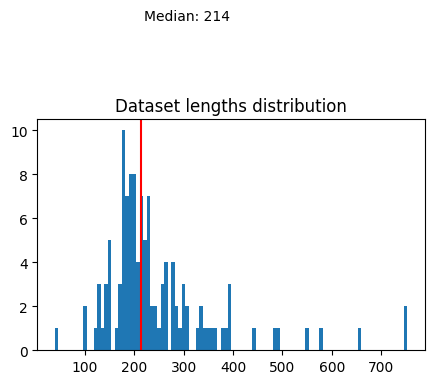

In [7]:
lengths = [x.shape[0] for x in X]
plt.figure(figsize=(5,3), dpi=100)
plt.hist(lengths, bins=100)
len_median = np.median(lengths)
plt.axvline(x=len_median, color='r')
plt.text(len_median + 5, 15, 'Median: {:.0f}'.format(len_median))
plt.title('Dataset lengths distribution')
plt.show()

### Finetuning ASTROMER

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from ASTROMER.preprocessing import make_pretraining
from ASTROMER.core.plots import plot_cm
from sklearn.metrics import confusion_matrix

%load_ext autoreload
%autoreload 2

2023-08-09 23:36:12.236462: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-09 23:36:12.237852: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 23:36:12.271031: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 23:36:12.271835: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 23:36:12.909363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.33, 
                                                  random_state=42)

n_classes = len(np.unique(y))

In [10]:
train_batches = make_pretraining(X_train,
                               batch_size=16,
                               shuffle= True,
                               sampling= True,
                               max_obs= 200,
                               msk_frac=0.,
                               rnd_frac=0.,
                               same_frac=0.,
                               repeat=1)

validation_batches = make_pretraining(X_val,
                                batch_size=16,
                                shuffle= True,
                                sampling= True,
                                max_obs= 200,
                                msk_frac=0.,
                                rnd_frac=0.,
                                same_frac=0.,
                                repeat=1)

[INFO] Loading Numpy
[INFO] no masking
[INFO] Loading Numpy


2023-08-09 23:36:14.557508: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


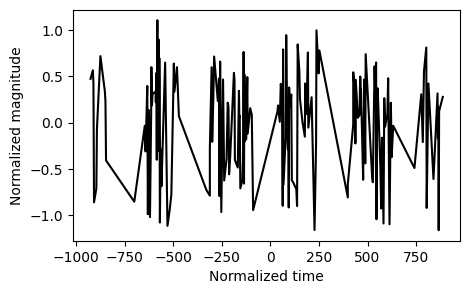

In [11]:
plt.figure(figsize=(5,3), dpi=100)
for batch in train_batches.take(1):
    sample_mags = tf.boolean_mask(batch['input'][0], 1.-batch['mask_in'][0])
    sample_time = tf.boolean_mask(batch['times'][0], 1.-batch['mask_in'][0])
    plt.plot(sample_time, sample_mags, color='k')
    plt.ylabel('Normalized magnitude')
    plt.xlabel('Normalized time')
    break

In [12]:
from ASTROMER.models import SingleBandEncoder
tf.config.run_functions_eagerly(True)

astromer = SingleBandEncoder()
astromer = astromer.from_pretraining('ztfg')

[INFO] Weights already downloaded


In [13]:
%%time
astromer.fit(train_batches,
             validation_batches,
             epochs=10,
             patience=20,
             lr=1e-3,
             project_path='./ztf_sne',
             verbose=0)

2023-08-09 23:36:16.083356: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/home/appa/miniconda3/envs/astromer/lib/python3.9/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['output', 'mask_out', 'label', 'id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
EPOCH 9 - ES COUNT: 3.0/20 train mse: 0.0692 - val mse: 0.0859: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.02s/it]

CPU times: user 1min 4s, sys: 1.11 s, total: 1min 5s
Wall time: 30.8 s


### Using embeddings to classify 

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
%%time
embeddings = astromer.encode(X, batch_size=16)

/home/appa/miniconda3/envs/astromer/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


[INFO] Loading numpy arrays
[INFO] no masking
CPU times: user 6.24 s, sys: 132 ms, total: 6.37 s
Wall time: 3.89 s


In [16]:
mean_embs = np.array([np.mean(x, 0) for x in embeddings])
mean_embs.shape

(120, 256)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(mean_embs, y, 
                                                    test_size=0.5, 
                                                    random_state=42)
X_train.shape

(60, 256)

In [18]:
y_train = np.array(y_train)[~np.isnan(np.mean(X_train, 1))]
X_train = X_train[~np.isnan(np.mean(X_train, 1))]

y_test = np.array(y_test)[~np.isnan(np.mean(X_test, 1))]
X_test = X_test[~np.isnan(np.mean(X_test, 1))]

In [19]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]))

In [20]:
clf = RandomForestClassifier(max_depth=2, random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=0)

In [21]:
y_pred = clf.predict(X_test)

In [22]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

<Axes: title={'center': 'CM'}>

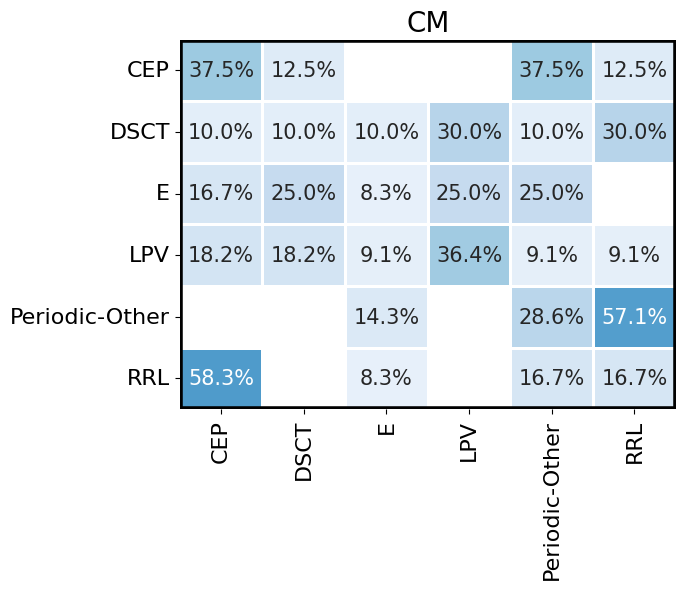

In [23]:
fig, ax = plt.subplots(1,1)
plot_cm(cm, ax, class_names=uniques)

### Using ASTROMER in a TensorFlow model 

In [24]:
from tensorflow.keras.layers import Dense, LayerNormalization, LSTM
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [25]:
astromer_encoder = astromer.model.get_layer('encoder')

In [26]:
def build_model(encoder, n_classes, maxlen, train_astromer=False, lr=1e-3):
    serie  = Input(shape=(maxlen, 1), batch_size=None, name='input')
    times  = Input(shape=(maxlen, 1), batch_size=None, name='times')
    mask   = Input(shape=(maxlen, 1), batch_size=None, name='mask')

    placeholder = {'input':serie,
                   'mask_in':mask,
                   'times':times}

    encoder.trainable = train_astromer
    
    mask = 1.-placeholder['mask_in']
    x = encoder(placeholder, training=False)
    x = x * mask
    x = tf.reduce_sum(x, 1)/tf.reduce_sum(mask, 1)

    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = LayerNormalization()(x)
    x = Dense(n_classes)(x)
    
    classifier = Model(inputs=placeholder, outputs=x, name="FCATT")
    
    classifier.compile(loss=CategoricalCrossentropy(from_logits=True), 
                       metrics=['accuracy'],
                       optimizer=Adam(lr))
    return classifier

In [27]:
classifier = build_model(astromer_encoder, 
                         n_classes, 
                         maxlen=astromer.maxlen,
                         train_astromer=False)

In [42]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, 
                                                  test_size=0.5, 
                                                  random_state=42)

In [51]:
train_batches = make_pretraining(X_train,
                               batch_size=16,
                               shuffle= True,
                               sampling= False,
                               max_obs= 200,
                               msk_frac=0.,
                               rnd_frac=0.,
                               same_frac=0.,
                               repeat=1,
                               n_classes=n_classes, # add this
                               labels=Y_train) # add tthis

validation_batches = make_pretraining(X_val,
                                batch_size=16,
                                shuffle= True,
                                sampling= False,
                                max_obs= 200,
                                msk_frac=0.,
                                rnd_frac=0.,
                                same_frac=0.,
                                repeat=1,
                                n_classes=n_classes,
                                labels=Y_val)

[INFO] Loading Numpy
[INFO] no masking
[INFO] Loading Numpy


/home/appa/miniconda3/envs/astromer/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


[INFO] no masking


In [52]:
history = classifier.fit(train_batches, 
                         epochs=50, 
                         validation_data=validation_batches,
                         callbacks=[EarlyStopping(patience=10)])

Epoch 1/50
7/7 [==============================] - 5s 740ms/step - loss: 1.8097 - accuracy: 0.2165 - val_loss: 1.7663 - val_accuracy: 0.2453
Epoch 2/50
7/7 [==============================] - 5s 704ms/step - loss: 1.8696 - accuracy: 0.1443 - val_loss: 1.7949 - val_accuracy: 0.1887
Epoch 3/50
7/7 [==============================] - 5s 720ms/step - loss: 1.8269 - accuracy: 0.1443 - val_loss: 1.7404 - val_accuracy: 0.1981
Epoch 4/50
7/7 [==============================] - 5s 719ms/step - loss: 1.7596 - accuracy: 0.2062 - val_loss: 1.7585 - val_accuracy: 0.2547
Epoch 5/50
7/7 [==============================] - 5s 706ms/step - loss: 1.8080 - accuracy: 0.1649 - val_loss: 1.7308 - val_accuracy: 0.1981
Epoch 6/50
7/7 [==============================] - 5s 705ms/step - loss: 1.7718 - accuracy: 0.1237 - val_loss: 1.7218 - val_accuracy: 0.3019
Epoch 7/50
7/7 [==============================] - 5s 718ms/step - loss: 1.7495 - accuracy: 0.1546 - val_loss: 1.7128 - val_accuracy: 0.2547
Epoch 8/50
7/7 [====

In [54]:
y_pred = classifier.predict(validation_batches)
y_pred = np.argmax(y_pred, 1)

7/7 [==============================] - 2s 279ms/step


In [55]:
y_test = np.concatenate([np.argmax(y, 1) for _, y in validation_batches])
y_test

array([0, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 2, 2, 5, 0, 0, 0, 1, 5, 2, 2, 0,
       0, 4, 4, 1, 1, 1, 1, 3, 0, 0, 1, 1, 0, 5, 2, 0, 0, 0, 5, 3, 3, 3,
       3, 3, 4, 4, 2, 2, 5, 5, 3, 5, 2, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 5,
       5, 0, 0, 1, 1, 1, 2, 2, 3, 2, 5, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1,
       2, 2, 2, 2, 4, 4, 3, 3, 5, 5, 1, 3, 3, 5, 5, 1, 1, 3])

In [56]:
cm_tf = confusion_matrix(y_test, y_pred, normalize='true')

<Axes: title={'center': 'TF'}>

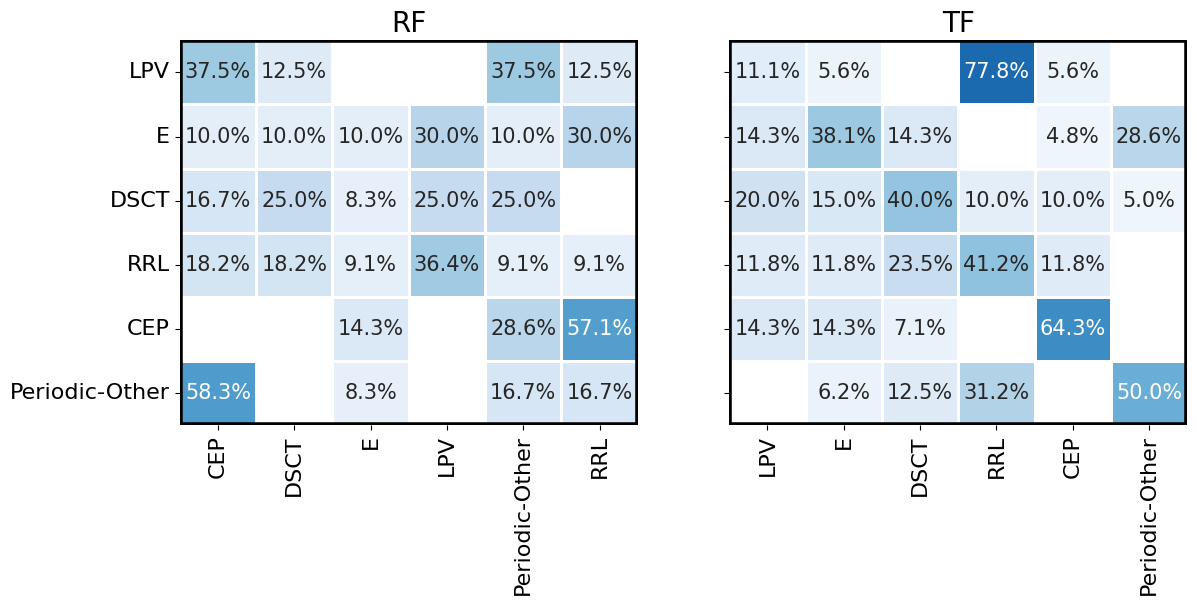

In [57]:
fig, axes = plt.subplots(1,2, figsize=(13,5),sharey=True)
plot_cm(cm, axes[0], class_names=uniques, title='RF')
plot_cm(cm_tf, axes[1], 
        class_names=objects_df_2['class'].unique() , title='TF')
